# Traffic signs detection project #
Section 1: extracting features and using them on 3 models.

In [61]:
import os 
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from sklearn import svm
from sklearn.naive_bayes import GaussianNB


path_base = os.getcwd() + "\\databases"
train, test = np.load(os.path.join(path_base,'train.npy')), np.load(os.path.join(path_base,'test.npy'))

### data changes and extraction

In [62]:
# Change array of pictures of size 45x45 to array of pictures 45*45=2025:
x1 = train
x1 = x1.astype("float32") / 255
rows, cols = (4170, 2025)
train = np.array([[0]*cols]*rows)
train = train.astype("float32")
jump = 0
for i in range(0,rows):
    for j in range(0, 45):
        for k in range(0, 45):
            train[i][jump] = x1[i][j][k]
            jump = jump + 1
    jump = 0


x2 = test
x2 = x2.astype("float32") / 255
rows, cols = (1998, 2025)
test = np.array([[0]*cols]*rows)
test = test.astype("float32")
jump = 0
for i in range(0,rows):
    for j in range(0, 45):
        for k in range(0, 45):
            test[i][jump] = x2[i][j][k]
            jump = jump + 1
    jump = 0

In [63]:
#get classification from files into arrays
path_pict = os.getcwd() + "\\pictures"

f = open(path_pict + "\\TsignRecgTrain4170Annotation.txt", "r")
str = f.read()

lines = str.split("\n")
arr = []
for line in lines:
    arr.append(int(line.split(";")[7]))
    
Train_classes = []
for i in range(58):
    for k in range(arr.count(i)):
        Train_classes.append(i)


f = open(path_pict + "\\TsignRecgTest1994Annotation.txt", "r")
str = f.read()

lines = str.split("\n")
arr = []
for line in lines:
    arr.append(int(line.split(";")[7]))
    
Test_classes = []
for i in range(58):
    for k in range(arr.count(i)):
        Test_classes.append(i)


### check the best amount of components for pca

above 0.9 is: (array([ 126,  127,  128, ..., 2022, 2023, 2024], dtype=int64),)


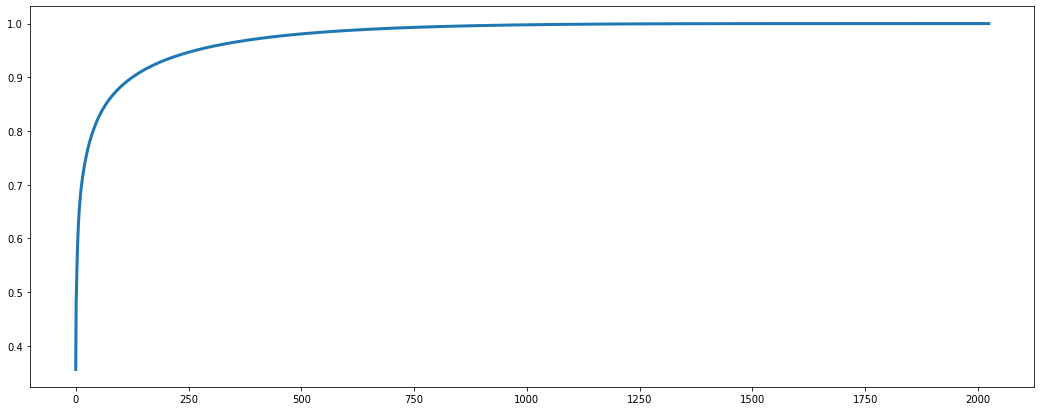

In [64]:
pca = PCA().fit(train)
plt.figure(figsize=(18, 7))
#lw stands for line width
plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3)
#cumsum stands for the sum of the variances by this point so when it is above .95 it will be about enough 
print("above 0.9 is:",np.where(pca.explained_variance_ratio_.cumsum() > 0.9))

### check the best amount of components for lda

above 0.9 is: (array([33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 55, 56], dtype=int64),)


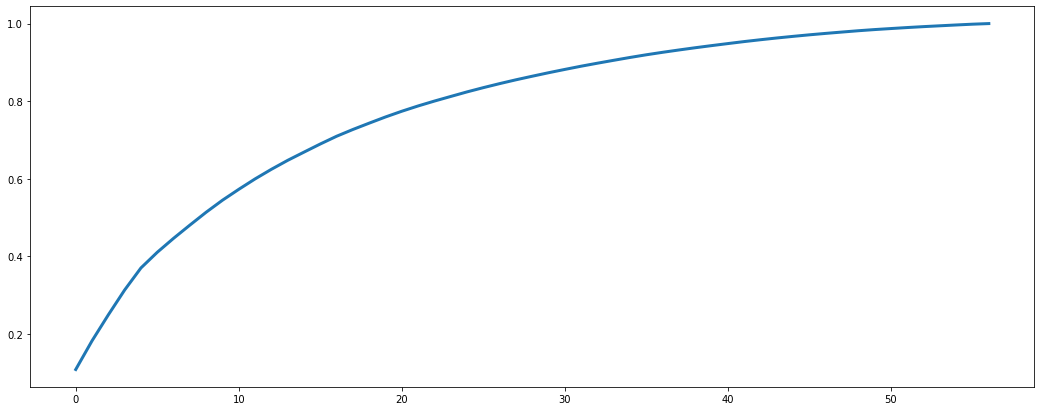

In [65]:
lda = LinearDiscriminantAnalysis().fit(train,Train_classes)
plt.figure(figsize=(18, 7))
plt.plot(lda.explained_variance_ratio_.cumsum(), lw=3)
print("above 0.9 is:",np.where(lda.explained_variance_ratio_.cumsum() > 0.9))

### Use PCA and LDA with best amount of components:

In [66]:
pca = PCA(n_components=120)
pca_train = pca.fit_transform(train)
pca_test = pca.transform(test)

lda = LinearDiscriminantAnalysis(n_components=30)
lda_train = lda.fit_transform(train,Train_classes)
lda_test = lda.transform(test)

### Print RF learning curves (PCA V.S LDA):

In [67]:
testErr_PCA = []
trainErr_PCA = []

testErr_LDA = []
trainErr_LDA = []

for i in range(170, 4170, 100):
    X_train = np.split(pca_train,[i,i])[0]
    y_train = np.split(Train_classes,[i,i])[0]
    clf1 = RandomForestClassifier()
    clf1.fit(X_train, y_train)
    trainErr_PCA.append(1-clf1.score(X_train, y_train))
    testErr_PCA.append(1-clf1.score(pca_test, Test_classes))

for i in range(170, 4170, 100):
    X_train = np.split(lda_train,[i,i])[0]
    y_train = np.split(Train_classes,[i,i])[0]    
    clf2 = RandomForestClassifier()
    clf2.fit(X_train, y_train)
    trainErr_LDA.append(1-clf2.score(X_train, y_train))
    testErr_LDA.append(1-clf2.score(lda_test, Test_classes))


RANDOM FOREST:


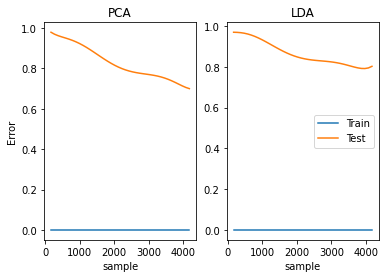

In [68]:
print('RANDOM FOREST:')
plt.xlabel("Samples")
plt.ylabel("Error")

x = np.linspace(170, 4170, 40) 
y1 = np.polyfit(x, trainErr_PCA, 6)
p1 = np.poly1d(y1)
y2 = np.polyfit(x, testErr_PCA, 6)
p2 = np.poly1d(y2)

y3 = np.polyfit(x, trainErr_LDA, 6) 
p3 = np.poly1d(y3)
y4 = np.polyfit(x, testErr_LDA, 6)
p4 = np.poly1d(y4)

plt.subplot(1, 2, 1)
plt.plot(x, p1(x), label="Train")
plt.plot(x, p2(x), label="Test")
plt.title("PCA")
plt.xlabel("sample")
plt.ylabel("Error")

plt.subplot(1, 2, 2) # index 2
plt.plot(x, p3(x), label="Train")
plt.plot(x, p4(x), label="Test")
plt.title("LDA")
plt.xlabel("sample")


plt.legend(loc="best") 
plt.show()

### from the learning curves we can see that we are at underfitted model(more data would be awsome)

In [69]:
clf1 = RandomForestClassifier()
clf1.fit(pca_train, Train_classes)
print("PCA:" ,clf1.score(pca_test, Test_classes))

clf2 = RandomForestClassifier()
clf2.fit(lda_train, Train_classes)
print("ldA:" ,clf2.score(lda_test, Test_classes))

PCA: 0.3013013013013013
ldA: 0.2022022022022022


### Print SVM learning curves (PCA V.S LDA):

In [70]:
testErr_PCA = []
trainErr_PCA = []

testErr_LDA = []
trainErr_LDA = []


for i in range(170, 4170, 100):
    X_train = np.split(pca_train,[i,i])[0]
    y_train = np.split(Train_classes,[i,i])[0]
    svc1 = svm.SVC(kernel='rbf')
    svc1.fit(X_train, y_train)
    trainErr_PCA.append(1-svc1.score(X_train, y_train))
    testErr_PCA.append(1-svc1.score(pca_test, Test_classes))

for i in range(170, 4170, 100):
    X_train = np.split(lda_train,[i,i])[0]
    y_train = np.split(Train_classes,[i,i])[0]    
    svc2 = svm.SVC(kernel='rbf')
    svc2.fit(X_train, y_train)
    trainErr_LDA.append(1-svc2.score(X_train, y_train))
    testErr_LDA.append(1-svc2.score(lda_test, Test_classes))



SVM:


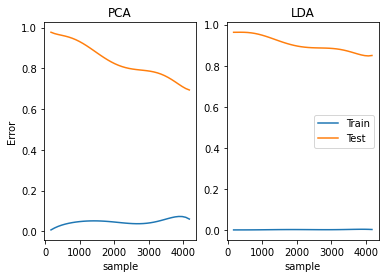

In [71]:
print('SVM:')
plt.xlabel("Samples")
plt.ylabel("Error")

x = np.linspace(170, 4170, 40) 
y1 = np.polyfit(x, trainErr_PCA, 6)
p1 = np.poly1d(y1)
y2 = np.polyfit(x, testErr_PCA, 6)
p2 = np.poly1d(y2)

y3 = np.polyfit(x, trainErr_LDA, 6) 
p3 = np.poly1d(y3)
y4 = np.polyfit(x, testErr_LDA, 6)
p4 = np.poly1d(y4)

plt.subplot(1, 2, 1)
plt.plot(x, p1(x), label="Train")
plt.plot(x, p2(x), label="Test")
plt.title("PCA")
plt.xlabel("sample")
plt.ylabel("Error")

plt.subplot(1, 2, 2)
plt.plot(x, p3(x), label="Train")
plt.plot(x, p4(x), label="Test")
plt.title("LDA")
plt.xlabel("sample")


plt.legend(loc="best") 
plt.show()

### just like in RF we need more data for PCA but LDA looks like he is almost reaching his pick!

In [72]:
svc1 = svm.SVC(kernel='rbf')
svc1.fit(pca_train, Train_classes)
print("PCA:", svc1.score(pca_test, Test_classes))

svc2 = svm.SVC(kernel='rbf')
svc2.fit(lda_train, Train_classes)
print("LDA:", svc2.score(lda_test, Test_classes))

PCA: 0.3048048048048048
LDA: 0.15315315315315314


### Print NB learning curves (PCA V.S LDA):

In [73]:
testErr_PCA = []
trainErr_PCA = []

testErr_LDA = []
trainErr_LDA = []


for i in range(170, 4170, 100):
    X_train = np.split(pca_train,[i,i])[0]
    y_train = np.split(Train_classes,[i,i])[0]
    gnb1 = GaussianNB()
    gnb1.fit(X_train, y_train)
    trainErr_PCA.append(1-gnb1.score(X_train, y_train))
    testErr_PCA.append(1-gnb1.score(pca_test, Test_classes))

for i in range(170, 4170, 100):
    X_train = np.split(lda_train,[i,i])[0]
    y_train = np.split(Train_classes,[i,i])[0]    
    gnb2 = GaussianNB()
    gnb2.fit(X_train, y_train)
    trainErr_LDA.append(1-gnb2.score(X_train, y_train))
    testErr_LDA.append(1-gnb2.score(lda_test, Test_classes))

GNB:


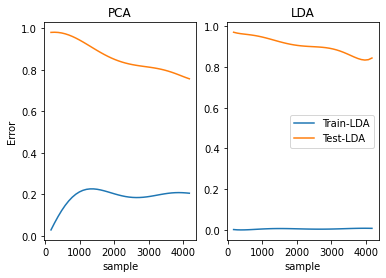

In [74]:
print('GNB:')
plt.xlabel("Samples")
plt.ylabel("Error")

x = np.linspace(170, 4170, 40) 
y1 = np.polyfit(x, trainErr_PCA, 6)
p1 = np.poly1d(y1)
y2 = np.polyfit(x, testErr_PCA, 6)
p2 = np.poly1d(y2)

y3 = np.polyfit(x, trainErr_LDA, 6) 
p3 = np.poly1d(y3)
y4 = np.polyfit(x, testErr_LDA, 6)
p4 = np.poly1d(y4)

plt.subplot(1, 2, 1)
plt.plot(x, p1(x), label="Train-PCA")
plt.plot(x, p2(x), label="Test-PCA")
plt.title("PCA")
plt.xlabel("sample")
plt.ylabel("Error")

plt.subplot(1, 2, 2)
plt.plot(x, p3(x), label="Train-LDA")
plt.plot(x, p4(x), label="Test-LDA")
plt.title("LDA")
plt.xlabel("sample")


plt.legend(loc="best") 
plt.show()

PCA would like more data!

In [75]:
gnb1 = GaussianNB()
gnb2 = GaussianNB()
gnb1.fit(pca_train, Train_classes)
gnb2.fit(lda_train, Train_classes)
print("pca:", gnb1.score(pca_test, Test_classes))
print("lda:", gnb2.score(lda_test, Test_classes))

pca: 0.24274274274274274
lda: 0.16416416416416416
